# Часть 2: Исследовательский анализ данных в Python и проверка гипотез. Знакомство с данными

Автор: Дмитриев Марк
Дата:3.09.2025

## Цели и задачи проекта

## Описание данных

Первый датасет final_tickets_orders_df.csv включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных. Поля датасета соответствуют таблице purchases, с которой вы работали в предыдущих заданиях:

- order_id — уникальный идентификатор заказа.
- user_id — уникальный идентификатор пользователя.
- created_dt_msk — дата создания заказа (московское время).
- created_ts_msk — дата и время создания заказа (московское время).
- event_id — идентификатор мероприятия из таблицы events.
- cinema_circuit — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- age_limit — возрастное ограничение мероприятия.
- currency_code — валюта оплаты, например rub для российских рублей.
- device_type_canonical — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- revenue — выручка от заказа.
- service_name — название билетного оператора.
- tickets_count — количество купленных билетов.
- total — общая сумма заказа.


В данные также был добавлен столбец days_since_prev с количеством дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.

Второй датасет final_tickets_events_df.csv содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. Датасет содержит такие поля:


- event_id — уникальный идентификатор мероприятия.
- event_name — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- event_type_description — описание типа мероприятия.
- event_type_main — основной тип мероприятия: театральная постановка, концерт и так далее.
- organizers — организаторы мероприятия.
- region_name — название региона.
- city_name — название города.
- venue_id — уникальный идентификатор площадки.
- venue_name — название площадки.
- venue_address — адрес площадки.


Выручка от заказов может бы представлена в разных валютах. Удобно будет привести данные к одной — к российским рублям. В вашем распоряжении будет датасет final_tickets_tenge_df.csv с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. Датасет содержит такие поля:


- nominal — номинал (100 тенге);
- data — дата;
- curs — курс тенге к рублю;
- cdx — обозначение валюты (kzt).

## Загрузка данных и знакомство с ними

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

In [2]:
final_tickets_orders=pd.read_csv('/datasets/final_tickets_orders_df.csv')
final_tickets_orders.head(5)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [3]:
print("=== final_tickets_orders ===")
print(f"Размер данных: {final_tickets_orders.shape}")
print("\nИнформация о данных:")
print(final_tickets_orders.info())
print("\nОписательная статистика:")
print(final_tickets_orders.describe())
print("\nПропущенные значения:")
print(final_tickets_orders.isnull().sum())

=== final_tickets_orders ===
Размер данных: (290849, 14)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since

In [4]:
final_tickets_events=pd.read_csv('/datasets/final_tickets_events_df.csv')
final_tickets_events.head(5)

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [5]:
print("\n=== final_tickets_events ===")
print(f"Размер данных: {final_tickets_events.shape}")
print("\nИнформация о данных:")
print(final_tickets_events.info())
print("\nПропущенные значения:")
print(final_tickets_events.isnull().sum())


=== final_tickets_events ===
Размер данных: (22427, 11)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB
None

Пропущенные значения:
event_id                  0
event_name                0
ev

In [6]:
final_tickets_tenge=pd.read_csv('/datasets/final_tickets_tenge_df.csv')
final_tickets_tenge.head(5)

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [7]:
print("\n=== final_tickets_tenge ===")
print(f"Размер данных: {final_tickets_tenge.shape}")
print("\nИнформация о данных:")
print(final_tickets_tenge.info())
print("\nПропущенные значения:")
print(final_tickets_tenge.isnull().sum())


=== final_tickets_tenge ===
Размер данных: (357, 4)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB
None

Пропущенные значения:
data       0
nominal    0
curs       0
cdx        0
dtype: int64


## Предобработка данных и подготовка их к исследованию

In [8]:
merged_df = final_tickets_orders.merge(final_tickets_events, on='event_id', how='left')
merged_df.head(5)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8"
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8"


In [9]:
# Проверим столбец 'cinema_circuit' более детально
print("Детальный анализ cinema_circuit:")
print(merged_df['cinema_circuit'].value_counts(dropna=False))
print(f"Процент значения 'нет': {merged_df['cinema_circuit'].value_counts(normalize=True).get('нет', 0)*100:.2f}%")

# Проверим столбец 'organizers'
print("\nДетальный анализ organizers:")
org_counts = merged_df['organizers'].value_counts()
print(f"Всего уникальных организаторов: {len(org_counts)}")
print("Топ-10 организаторов:")
print(org_counts.head(10))
# Анализ currency_code
print("\n2. АНАЛИЗ currency_code:")
currency_analysis = merged_df['currency_code'].value_counts()
print(currency_analysis)
# Анализ device_type_canonical
print("\n3. АНАЛИЗ device_type_canonical:")
device_analysis = merged_df['device_type_canonical'].value_counts()
print(device_analysis)
# Анализ age_limit - хотя числовой, но может быть категориальным
print("\n6. АНАЛИЗ age_limit:")
age_analysis = merged_df['age_limit'].value_counts().sort_index()
print(age_analysis)
# Анализ event_type_description и event_type_main
print("\n1. АНАЛИЗ ТИПОВ СОБЫТИЙ:")
print("event_type_description:")
print(merged_df['event_type_description'].value_counts())
print("\nevent_type_main:")
print(merged_df['event_type_main'].value_counts())
#Анализ географических данных
print("\n3. АНАЛИЗ ГЕОГРАФИЧЕСКИХ ДАННЫХ:")
print("region_name - уникальные регионы:")
print(merged_df['region_name'].value_counts().head(10))
print(f"\nВсего уникальных регионов: {merged_df['region_name'].nunique()}")

print("\ncity_name - уникальные города:")
print(merged_df['city_name'].value_counts().head(10))
print(f"\nВсего уникальных городов: {merged_df['city_name'].nunique()}")

# Анализ venue_name и venue_address
print("\n4. АНАЛИЗ МЕСТ ПРОВЕДЕНИЯ:")
print("venue_name - примеры названий:")
print(merged_df['venue_name'].value_counts().head(10))
print(f"\nВсего уникальных мест: {merged_df['venue_name'].nunique()}")

Детальный анализ cinema_circuit:
нет           289451
Другое          1261
КиноСити         122
Киномакс           7
Москино            7
ЦентрФильм         1
Name: cinema_circuit, dtype: int64
Процент значения 'нет': 99.52%

Детальный анализ organizers:
Всего уникальных организаторов: 4293
Топ-10 организаторов:
№1531    9748
№2121    4738
№4054    4362
№4549    3972
№4837    3368
№4086    3323
№4950    3212
№4403    3037
№5085    3005
№2378    2886
Name: organizers, dtype: int64

2. АНАЛИЗ currency_code:
rub    285780
kzt      5069
Name: currency_code, dtype: int64

3. АНАЛИЗ device_type_canonical:
mobile     232679
desktop     58170
Name: device_type_canonical, dtype: int64

6. АНАЛИЗ age_limit:
0     61487
6     52173
12    62557
16    78579
18    36053
Name: age_limit, dtype: int64

1. АНАЛИЗ ТИПОВ СОБЫТИЙ:
event_type_description:
концерт                   112049
событие                    58605
спектакль                  50592
шоу                        13626
спорт                

In [10]:
# Разделим данные по валютам
rub_data = merged_df[merged_df['currency_code'] == 'rub']
kzt_data = merged_df[merged_df['currency_code'] == 'kzt'] if 'kzt' in merged_df['currency_code'].values else None
other_currencies = merged_df[~merged_df['currency_code'].isin(['rub', 'kzt'])] if 'kzt' in merged_df['currency_code'].values else merged_df[merged_df['currency_code'] != 'RUB']

print("РАСПРЕДЕЛЕНИЕ ПО ВАЛЮТАМ:")
print(f"rub: {len(rub_data)} записей ({len(rub_data)/len(merged_df)*100:.1f}%)")
if kzt_data is not None:
    print(f"kzt: {len(kzt_data)} записей ({len(kzt_data)/len(merged_df)*100:.1f}%)")
if len(other_currencies) > 0:
    print(f"Другие валюты: {len(other_currencies)} записей")

# Статистика по revenue для каждой валюты
print("\nСТАТИСТИКА REVENUE ПО ВАЛЮТАМ:")
print("\nrub:")
print(rub_data['revenue'].describe())

if kzt_data is not None:
    print("\nkzt:")
    print(kzt_data['revenue'].describe())

if len(other_currencies) > 0:
    print("\nДругие валюты:")
    print(other_currencies['revenue'].describe())

РАСПРЕДЕЛЕНИЕ ПО ВАЛЮТАМ:
rub: 285780 записей (98.3%)
kzt: 5069 записей (1.7%)

СТАТИСТИКА REVENUE ПО ВАЛЮТАМ:

rub:
count    285780.000000
mean        547.568333
std         871.524559
min         -90.760000
25%         113.827500
50%         346.100000
75%         791.700000
max       81174.540000
Name: revenue, dtype: float64

kzt:
count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64


/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


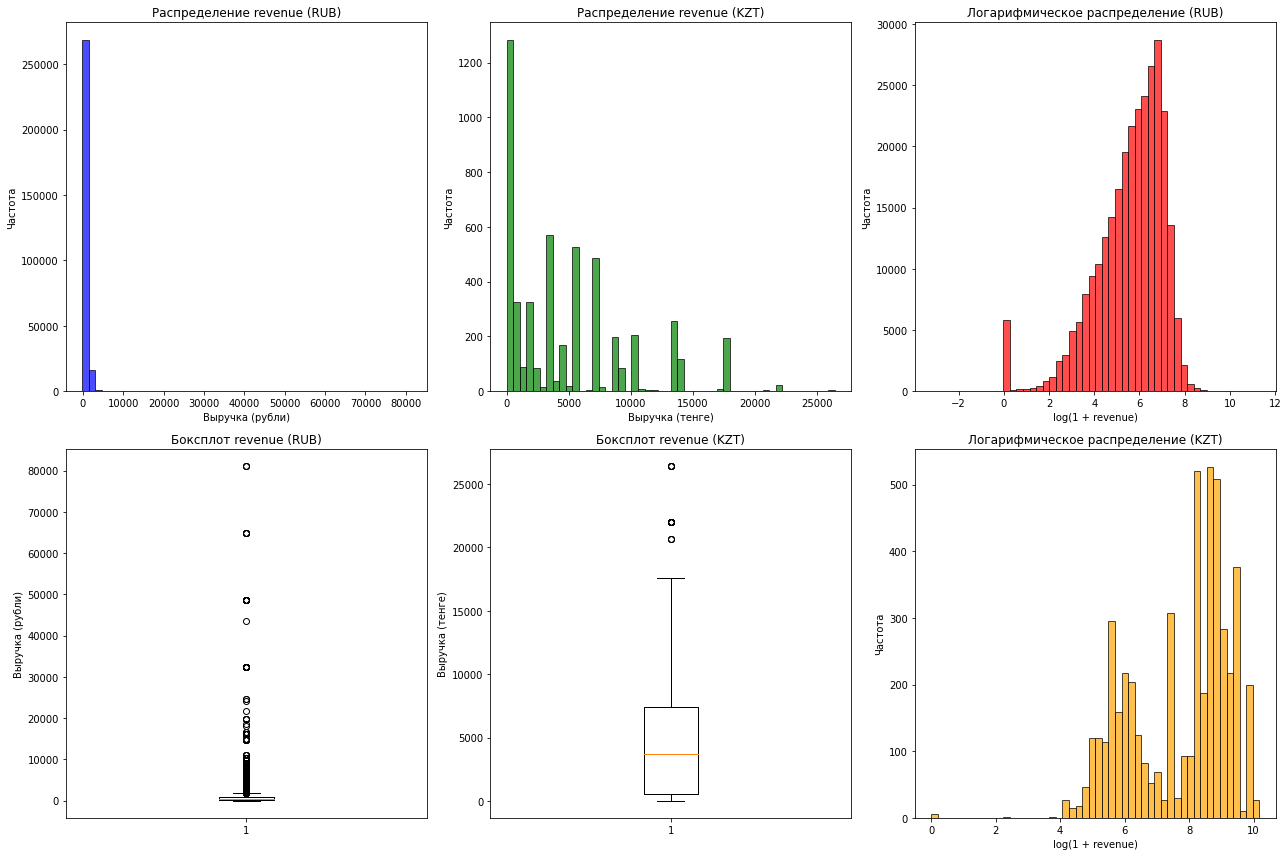

In [11]:
# Создаем графики для анализа распределения
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Гистограммы распределения
# RUB
axes[0, 0].hist(rub_data['revenue'], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title('Распределение revenue (RUB)')
axes[0, 0].set_xlabel('Выручка (рубли)')
axes[0, 0].set_ylabel('Частота')

# KZT (если есть)
if kzt_data is not None:
    axes[0, 1].hist(kzt_data['revenue'], bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].set_title('Распределение revenue (KZT)')
    axes[0, 1].set_xlabel('Выручка (тенге)')
    axes[0, 1].set_ylabel('Частота')

# Боксплоты для выявления выбросов
# RUB
axes[1, 0].boxplot(rub_data['revenue'])
axes[1, 0].set_title('Боксплот revenue (RUB)')
axes[1, 0].set_ylabel('Выручка (рубли)')

# KZT (если есть)
if kzt_data is not None:
    axes[1, 1].boxplot(kzt_data['revenue'])
    axes[1, 1].set_title('Боксплот revenue (KZT)')
    axes[1, 1].set_ylabel('Выручка (тенге)')

# Логарифмическое распределение для лучшей визуализации
axes[0, 2].hist(np.log1p(rub_data['revenue']), bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0, 2].set_title('Логарифмическое распределение (RUB)')
axes[0, 2].set_xlabel('log(1 + revenue)')
axes[0, 2].set_ylabel('Частота')

if kzt_data is not None:
    axes[1, 2].hist(np.log1p(kzt_data['revenue']), bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 2].set_title('Логарифмическое распределение (KZT)')
    axes[1, 2].set_xlabel('log(1 + revenue)')
    axes[1, 2].set_ylabel('Частота')

plt.tight_layout()
plt.show()

In [12]:
# Функция для анализа выбросов по перцентилям
def analyze_outliers(data, currency_name):
    print(f"\nАНАЛИЗ ВЫБРОСОВ ДЛЯ {currency_name}:")
    print("="*40)
    
    # Рассчитаем различные перцентили
    percentiles = [25, 50, 75, 90, 95, 99, 99.5, 99.9, 99.99]
    percentile_values = np.percentile(data['revenue'], percentiles)
    
    for p, val in zip(percentiles, percentile_values):
        print(f"{p}%-й перцентиль: {val:.2f}")
    
    # Определим выбросы по 99-му перцентилю
    threshold_99 = np.percentile(data['revenue'], 99)
    outliers_99 = data[data['revenue'] > threshold_99]
    
    print(f"\nПорог по 99-му перцентилю: {threshold_99:.2f}")
    print(f"Количество выбросов (>99%): {len(outliers_99)}")
    print(f"Доля выбросов: {len(outliers_99)/len(data)*100:.2f}%")
    
    # Статистика по выбросам
    if len(outliers_99) > 0:
        print(f"Мин. значение выбросов: {outliers_99['revenue'].min():.2f}")
        print(f"Макс. значение выбросов: {outliers_99['revenue'].max():.2f}")
        print(f"Среднее значение выбросов: {outliers_99['revenue'].mean():.2f}")
    
    return threshold_99, outliers_99

# Анализ для RUB
threshold_rub, outliers_rub = analyze_outliers(rub_data, "RUB")

# Анализ для KZT (если есть)
if kzt_data is not None:
    threshold_kzt, outliers_kzt = analyze_outliers(kzt_data, "KZT")


АНАЛИЗ ВЫБРОСОВ ДЛЯ RUB:
25%-й перцентиль: 113.83
50%-й перцентиль: 346.10
75%-й перцентиль: 791.70
90%-й перцентиль: 1276.15
95%-й перцентиль: 1606.50
99%-й перцентиль: 2569.59
99.5%-й перцентиль: 2988.16
99.9%-й перцентиль: 5140.78
99.99%-й перцентиль: 32469.82

Порог по 99-му перцентилю: 2569.59
Количество выбросов (>99%): 2858
Доля выбросов: 1.00%
Мин. значение выбросов: 2569.61
Макс. значение выбросов: 81174.54
Среднее значение выбросов: 4269.81

АНАЛИЗ ВЫБРОСОВ ДЛЯ KZT:
25%-й перцентиль: 518.10
50%-й перцентиль: 3698.83
75%-й перцентиль: 7397.66
90%-й перцентиль: 13212.93
95%-й перцентиль: 13784.26
99%-й перцентиль: 17617.24
99.5%-й перцентиль: 21564.20
99.9%-й перцентиль: 22021.55
99.99%-й перцентиль: 26425.86

Порог по 99-му перцентилю: 17617.24
Количество выбросов (>99%): 29
Доля выбросов: 0.57%
Мин. значение выбросов: 20676.39
Макс. значение выбросов: 26425.86
Среднее значение выбросов: 22641.76



АНАЛИЗ TICKETS_COUNT
Общая статистика tickets_count:
count    290849.000000
mean          2.754230
std           1.170467
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

Tickets_count по валютам:
RUB:
count    285780.000000
mean          2.754077
std           1.171419
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

KZT:
count    5069.000000
mean        2.762872
std         1.115558
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: tickets_count, dtype: float64


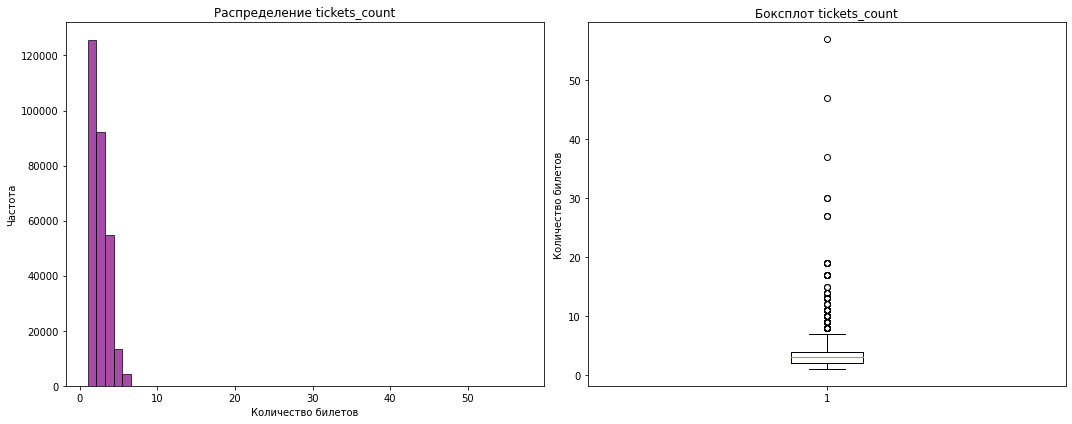


Выбросы в tickets_count (>99%):
Порог: 6.0 билетов
Количество выбросов: 188
Максимальное значение: 57 билетов


In [13]:
# Проверим наличие tickets_count и проанализируем его
if 'tickets_count' in merged_df.columns:
    print("\n" + "="*50)
    print("АНАЛИЗ TICKETS_COUNT")
    print("="*50)
    
    # Основная статистика
    print("Общая статистика tickets_count:")
    print(merged_df['tickets_count'].describe())
    
    # Распределение по валютам
    print("\nTickets_count по валютам:")
    print("RUB:")
    print(rub_data['tickets_count'].describe())
    
    if kzt_data is not None:
        print("\nKZT:")
        print(kzt_data['tickets_count'].describe())
    
    # Визуализация распределения tickets_count
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Гистограмма
    axes[0].hist(merged_df['tickets_count'], bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[0].set_title('Распределение tickets_count')
    axes[0].set_xlabel('Количество билетов')
    axes[0].set_ylabel('Частота')
    
    # Боксплот
    axes[1].boxplot(merged_df['tickets_count'])
    axes[1].set_title('Боксплот tickets_count')
    axes[1].set_ylabel('Количество билетов')
    
    plt.tight_layout()
    plt.show()
    
    # Анализ выбросов в tickets_count
    tickets_threshold_99 = np.percentile(merged_df['tickets_count'], 99)
    tickets_outliers = merged_df[merged_df['tickets_count'] > tickets_threshold_99]
    
    print(f"\nВыбросы в tickets_count (>99%):")
    print(f"Порог: {tickets_threshold_99} билетов")
    print(f"Количество выбросов: {len(tickets_outliers)}")
    print(f"Максимальное значение: {merged_df['tickets_count'].max()} билетов")
    
else:
    print("Столбец tickets_count отсутствует в данных")

In [14]:
# Создаем отфильтрованные датафреймы без выбросов
print("\n" + "="*50)
print("ФИЛЬТРАЦИЯ ДАННЫХ ПО 99-МУ ПЕРЦЕНТИЛЮ")
print("="*50)

# Фильтруем RUB данные
filtered_rub_data = rub_data[rub_data['revenue'] <= threshold_rub]
print(f"RUB данные до фильтрации: {len(rub_data)} записей")
print(f"RUB данные после фильтрации: {len(filtered_rub_data)} записей")
print(f"Удалено записей RUB: {len(rub_data) - len(filtered_rub_data)}")

# Фильтруем KZT данные (если есть)
if kzt_data is not None:
    filtered_kzt_data = kzt_data[kzt_data['revenue'] <= threshold_kzt]
    print(f"\nKZT данные до фильтрации: {len(kzt_data)} записей")
    print(f"KZT данные после фильтрации: {len(filtered_kzt_data)} записей")
    print(f"Удалено записей KZT: {len(kzt_data) - len(filtered_kzt_data)}")

# Объединяем отфильтрованные данные
filtered_data_list = [filtered_rub_data]
if kzt_data is not None:
    filtered_data_list.append(filtered_kzt_data)
if len(other_currencies) > 0:
    filtered_data_list.append(other_currencies)

filtered_df = pd.concat(filtered_data_list, ignore_index=True)

print(f"\nОбщий размер данных до фильтрации: {len(merged_df)}")
print(f"Общий размер данных после фильтрации: {len(filtered_df)}")
print(f"Общее количество удаленных выбросов: {len(merged_df) - len(filtered_df)}")


ФИЛЬТРАЦИЯ ДАННЫХ ПО 99-МУ ПЕРЦЕНТИЛЮ
RUB данные до фильтрации: 285780 записей
RUB данные после фильтрации: 282922 записей
Удалено записей RUB: 2858

KZT данные до фильтрации: 5069 записей
KZT данные после фильтрации: 5040 записей
Удалено записей KZT: 29

Общий размер данных до фильтрации: 290849
Общий размер данных после фильтрации: 287962
Общее количество удаленных выбросов: 2887



СРАВНЕНИЕ СТАТИСТИК ДО И ПОСЛЕ ФИЛЬТРАЦИИ
REVENUE (RUB) - ДО фильтрации:
count    285780.000000
mean        547.568333
std         871.524559
min         -90.760000
25%         113.827500
50%         346.100000
75%         791.700000
max       81174.540000
Name: revenue, dtype: float64

REVENUE (RUB) - ПОСЛЕ фильтрации:
count    282922.000000
mean        509.967304
std         500.112654
min         -90.760000
25%         111.660000
50%         340.250000
75%         781.090000
max        2569.590000
Name: revenue, dtype: float64

REVENUE (KZT) - ДО фильтрации:
count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64

REVENUE (KZT) - ПОСЛЕ фильтрации:
count     5040.000000
mean      4893.669063
std       4742.680176
min          0.000000
25%        515.350000
50%       3698.830000
75%       7397.660000
max      17617.240000
Name: revenue,

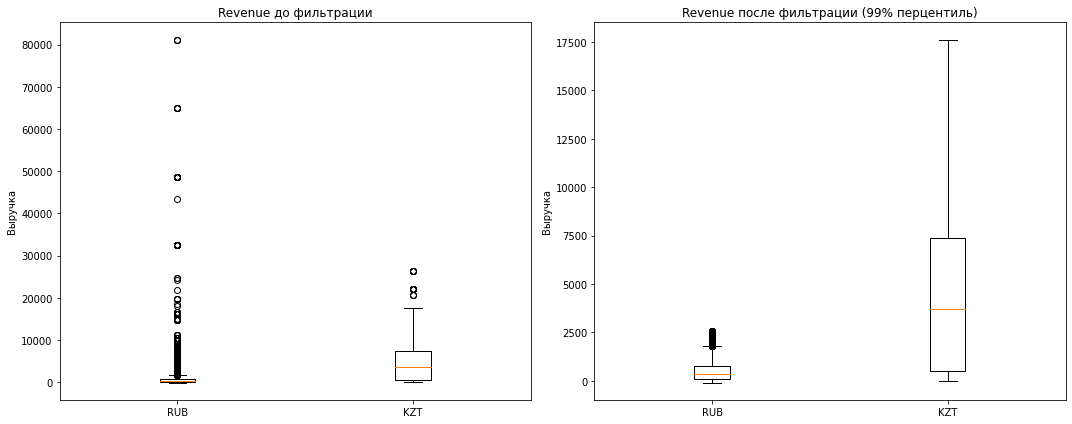

In [15]:
# Сравним статистики до и после фильтрации
print("\n" + "="*50)
print("СРАВНЕНИЕ СТАТИСТИК ДО И ПОСЛЕ ФИЛЬТРАЦИИ")
print("="*50)

print("REVENUE (RUB) - ДО фильтрации:")
print(rub_data['revenue'].describe())

print("\nREVENUE (RUB) - ПОСЛЕ фильтрации:")
print(filtered_rub_data['revenue'].describe())

if kzt_data is not None:
    print("\nREVENUE (KZT) - ДО фильтрации:")
    print(kzt_data['revenue'].describe())
    
    print("\nREVENUE (KZT) - ПОСЛЕ фильтрации:")
    print(filtered_kzt_data['revenue'].describe())

# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# До фильтрации
axes[0].boxplot([rub_data['revenue']] + ([kzt_data['revenue']] if kzt_data is not None else []))
axes[0].set_title('Revenue до фильтрации')
axes[0].set_ylabel('Выручка')
labels = ['RUB'] + (['KZT'] if kzt_data is not None else [])
axes[0].set_xticklabels(labels)

# После фильтрации
axes[1].boxplot([filtered_rub_data['revenue']] + ([filtered_kzt_data['revenue']] if kzt_data is not None else []))
axes[1].set_title('Revenue после фильтрации (99% перцентиль)')
axes[1].set_ylabel('Выручка')
axes[1].set_xticklabels(labels)

plt.tight_layout()
plt.show()

In [16]:
# Проверим полные дубликаты строк
print("ПРОВЕРКА ЯВНЫХ ДУБЛИКАТОВ")
print("="*50)

total_duplicates = merged_df.duplicated().sum()
print(f"Полных дубликатов строк: {total_duplicates}")

if total_duplicates > 0:
    print("Примеры дубликатов:")
    duplicate_rows = merged_df[merged_df.duplicated(keep=False)]
    print(duplicate_rows.head(10))

# Проверим дубликаты по order_id (должен быть уникальным)
print(f"\nПроверка уникальности order_id:")
print(f"Всего заказов: {merged_df['order_id'].nunique()}")
print(f"Всего строк: {len(merged_df)}")
print(f"Дубликатов order_id: {len(merged_df) - merged_df['order_id'].nunique()}")

if len(merged_df) != merged_df['order_id'].nunique():
    duplicate_orders = merged_df[merged_df.duplicated(subset=['order_id'], keep=False)]
    print(f"\nНайдены дубликаты order_id. Примеры:")
    print(duplicate_orders.sort_values('order_id').head(10))

ПРОВЕРКА ЯВНЫХ ДУБЛИКАТОВ
Полных дубликатов строк: 0

Проверка уникальности order_id:
Всего заказов: 290849
Всего строк: 290849
Дубликатов order_id: 0


In [17]:
# Определим ключевые параметры для идентификации дубликатов бронирований
booking_columns = ['user_id', 'created_dt_msk', 'event_id','event_name', 'venue_id', 'revenue','city_name','tickets_count','device_type_canonical']

print("\nПОИСК НЕЯВНЫХ ДУБЛИКАТОВ БРОНИРОВАНИЙ")
print("="*50)
print("Ключевые параметры для поиска дубликатов:", booking_columns)

# Поиск потенциальных дубликатов бронирований
potential_duplicates = merged_df[merged_df.duplicated(subset=booking_columns, keep=False)]
print(f"Найдено потенциальных дубликатов бронирований: {len(potential_duplicates)}")

if len(potential_duplicates) > 0:
    print(f"Уникальных комбинаций дубликатов: {potential_duplicates.duplicated(subset=booking_columns).sum()}")
    
    # Сгруппируем по ключевым параметрам для анализа
    duplicate_groups = potential_duplicates.groupby(booking_columns).size().reset_index(name='count')
    duplicate_groups = duplicate_groups[duplicate_groups['count'] > 1]
    
    print(f"\nГруппы дубликатов (более 1 записи): {len(duplicate_groups)}")
    print(duplicate_groups.head(10))


ПОИСК НЕЯВНЫХ ДУБЛИКАТОВ БРОНИРОВАНИЙ
Ключевые параметры для поиска дубликатов: ['user_id', 'created_dt_msk', 'event_id', 'event_name', 'venue_id', 'revenue', 'city_name', 'tickets_count', 'device_type_canonical']
Найдено потенциальных дубликатов бронирований: 84396
Уникальных комбинаций дубликатов: 51628

Группы дубликатов (более 1 записи): 32744
           user_id created_dt_msk  event_id  \
0  000cf0659a9f40f     2024-06-20    516728   
1  000cf0659a9f40f     2024-06-20    516728   
2  000cf0659a9f40f     2024-06-21    516728   
3  0020c5654c92ec1     2024-07-02    514156   
4  002ec276eee9b0b     2024-07-28    535695   
5  002ec276eee9b0b     2024-09-21    534009   
6  0033403583a55ed     2024-06-19    538926   
7  00345f897f95a34     2024-08-31    522858   
8  00345f897f95a34     2024-10-23    245958   
9  0062ac9536d57e3     2024-08-11    523658   

                             event_name  venue_id  revenue     city_name  \
0  11be386f-7cb7-4aa1-a8e4-ba73a29c1af2    4471.0   710

In [18]:
print("\nПРЕОБРАЗОВАНИЕ ДАТ И ВРЕМЕНИ")
print("="*50)

# Анализ форматов дат
date_time_columns = ['created_dt_msk', 'created_ts_msk']
for col in date_time_columns:
    if col in merged_df.columns:
        print(f"\nАнализ {col}:")
        print(f"Тип: {merged_df[col].dtype}")
        print(f"Примеры: {merged_df[col].head(3).tolist()}")
        print(f"Пропуски: {merged_df[col].isnull().sum()}")

# Преобразование в правильные типы datetime
def optimize_datetime_types(df):
    df_optimized = df.copy()
    
    # Преобразование created_dt_msk в date
    if 'created_dt_msk' in df_optimized.columns:
        df_optimized['created_dt_msk'] = pd.to_datetime(df_optimized['created_dt_msk'], errors='coerce')
        print(f"created_dt_msk преобразован в datetime")
    
    # Преобразование created_ts_msk в datetime
    if 'created_ts_msk' in df_optimized.columns:
        df_optimized['created_ts_msk'] = pd.to_datetime(df_optimized['created_ts_msk'], errors='coerce')
        print(f"created_ts_msk преобразован в datetime")
    
    # Создание дополнительных временных признаков
    if 'created_ts_msk' in df_optimized.columns:
        df_optimized['created_year'] = df_optimized['created_ts_msk'].dt.year
        df_optimized['created_month'] = df_optimized['created_ts_msk'].dt.month
        df_optimized['created_day'] = df_optimized['created_ts_msk'].dt.day
        df_optimized['created_hour'] = df_optimized['created_ts_msk'].dt.hour
        df_optimized['created_dayofweek'] = df_optimized['created_ts_msk'].dt.dayofweek
        df_optimized['created_week'] = df_optimized['created_ts_msk'].dt.isocalendar().week
        
        print("Созданы дополнительные временные признаки")
    
    return df_optimized

# Применяем преобразование
merged_df_optimized = optimize_datetime_types(merged_df)

# Проверяем результат
print("\nРезультат преобразования дат:")
for col in date_time_columns:
    if col in merged_df_optimized.columns:
        print(f"{col}: {merged_df_optimized[col].dtype}")
        print(f"Диапазон: {merged_df_optimized[col].min()} - {merged_df_optimized[col].max()}")


ПРЕОБРАЗОВАНИЕ ДАТ И ВРЕМЕНИ

Анализ created_dt_msk:
Тип: object
Примеры: ['2024-08-20', '2024-07-23', '2024-10-06']
Пропуски: 0

Анализ created_ts_msk:
Тип: object
Примеры: ['2024-08-20 16:08:03', '2024-07-23 18:36:24', '2024-10-06 13:56:02']
Пропуски: 0
created_dt_msk преобразован в datetime
created_ts_msk преобразован в datetime
Созданы дополнительные временные признаки

Результат преобразования дат:
created_dt_msk: datetime64[ns]
Диапазон: 2024-06-01 00:00:00 - 2024-10-31 00:00:00
created_ts_msk: datetime64[ns]
Диапазон: 2024-06-01 00:00:42 - 2024-10-31 23:59:54


In [19]:
print("\nОПТИМИЗАЦИЯ ЧИСЛОВЫХ ТИПОВ")
print("="*50)

def optimize_numeric_types(df):
    df_opt = df.copy()
    numeric_columns = df_opt.select_dtypes(include=[np.number]).columns
    
    print("Оптимизация числовых колонок:")
    for col in numeric_columns:
        original_dtype = df_opt[col].dtype
        original_memory = df_opt[col].memory_usage(deep=True) / 1024  # KB
        
        # Пропуски заполняем специальным значением перед оптимизацией
        col_series = df_opt[col].fillna(-1) if df_opt[col].isnull().any() else df_opt[col]
        
        # Определяем оптимальный тип
        if col_series.dtype.kind in 'iuf':  # integer, unsigned, float
            col_min = col_series.min()
            col_max = col_series.max()
            
            if col_series.dtype.kind == 'f':  # float
                # Для float пытаемся преобразовать в float32
                if np.isfinite(col_min) and np.isfinite(col_max):
                    if col_min >= np.finfo(np.float16).min and col_max <= np.finfo(np.float16).max:
                        new_dtype = np.float16
                    elif col_min >= np.finfo(np.float32).min and col_max <= np.finfo(np.float32).max:
                        new_dtype = np.float32
                    else:
                        new_dtype = np.float64
            else:  # integer
                # Для integer подбираем минимальный подходящий тип
                if col_min >= 0:  # unsigned
                    if col_max <= np.iinfo(np.uint8).max:
                        new_dtype = np.uint8
                    elif col_max <= np.iinfo(np.uint16).max:
                        new_dtype = np.uint16
                    elif col_max <= np.iinfo(np.uint32).max:
                        new_dtype = np.uint32
                    else:
                        new_dtype = np.uint64
                else:  # signed
                    if col_min >= np.iinfo(np.int8).min and col_max <= np.iinfo(np.int8).max:
                        new_dtype = np.int8
                    elif col_min >= np.iinfo(np.int16).min and col_max <= np.iinfo(np.int16).max:
                        new_dtype = np.int16
                    elif col_min >= np.iinfo(np.int32).min and col_max <= np.iinfo(np.int32).max:
                        new_dtype = np.int32
                    else:
                        new_dtype = np.int64
            
            # Применяем преобразование если есть выигрыш
            if new_dtype != original_dtype:
                df_opt[col] = df_opt[col].astype(new_dtype)
                new_memory = df_opt[col].memory_usage(deep=True) / 1024
                savings = (original_memory - new_memory) / original_memory * 100
                print(f"  {col:25} | {original_dtype} -> {new_dtype} | Экономия: {savings:5.1f}%")
    
    return df_opt

# Применяем оптимизацию
merged_df_optimized = optimize_numeric_types(merged_df_optimized)


ОПТИМИЗАЦИЯ ЧИСЛОВЫХ ТИПОВ
Оптимизация числовых колонок:
  order_id                  | int64 -> <class 'numpy.uint32'> | Экономия:  25.0%
  event_id                  | int64 -> <class 'numpy.uint32'> | Экономия:  25.0%
  age_limit                 | int64 -> <class 'numpy.uint8'> | Экономия:  43.8%
  revenue                   | float64 -> <class 'numpy.float32'> | Экономия:  25.0%
  tickets_count             | int64 -> <class 'numpy.uint8'> | Экономия:  43.8%
  total                     | float64 -> <class 'numpy.float32'> | Экономия:  25.0%
  days_since_prev           | float64 -> <class 'numpy.float16'> | Экономия:  37.5%
  city_id                   | float64 -> <class 'numpy.float16'> | Экономия:  37.5%
  venue_id                  | float64 -> <class 'numpy.float16'> | Экономия:  37.5%
  created_year              | int64 -> <class 'numpy.uint16'> | Экономия:  37.5%
  created_month             | int64 -> <class 'numpy.uint8'> | Экономия:  43.8%
  created_day               | int64 -> 

In [20]:
# Преобразуем дату в правильный формат
final_tickets_tenge['data'] = pd.to_datetime(final_tickets_tenge['data'])
# Рассчитаем курс для 1 тенге (в данных курс указан для 100 тенге)
final_tickets_tenge['curs_per_unit'] = final_tickets_tenge['curs'] / final_tickets_tenge['nominal']
print(f"\nКурс 1 тенге к рублю: в диапазоне {final_tickets_tenge['curs_per_unit'].min():.4f} - {final_tickets_tenge['curs_per_unit'].max():.4f}")


Курс 1 тенге к рублю: в диапазоне 0.1785 - 0.2194


In [21]:
# Преобразуем даты в правильный формат если еще не сделано
if 'created_dt_msk' in merged_df.columns and merged_df['created_dt_msk'].dtype == 'object':
    merged_df['created_dt_msk'] = pd.to_datetime(merged_df['created_dt_msk'])

if 'created_ts_msk' in merged_df.columns and merged_df['created_ts_msk'].dtype == 'object':
    merged_df['created_ts_msk'] = pd.to_datetime(merged_df['created_ts_msk'])

print("БАЗОВАЯ ИНФОРМАЦИЯ О ДАННЫХ:")
print(f"Размер данных: {merged_df.shape}")
print(f"Валюты в данных: {merged_df['currency_code'].value_counts().to_dict()}")

БАЗОВАЯ ИНФОРМАЦИЯ О ДАННЫХ:
Размер данных: (290849, 24)
Валюты в данных: {'rub': 285780, 'kzt': 5069}


In [22]:
# Простое объединение по дате
result_df = merged_df.merge(
    final_tickets_tenge.rename(columns={'data': 'created_dt_msk'}), 
    on='created_dt_msk', 
    how='left'
)

print(result_df.head(5))

   order_id          user_id created_dt_msk      created_ts_msk  event_id  \
0   4359165  0002849b70a3ce2     2024-08-20 2024-08-20 16:08:03    169230   
1   7965605  0005ca5e93f2cf4     2024-07-23 2024-07-23 18:36:24    237325   
2   7292370  0005ca5e93f2cf4     2024-10-06 2024-10-06 13:56:02    578454   
3   1139875  000898990054619     2024-07-13 2024-07-13 19:40:48    387271   
4    972400  000898990054619     2024-10-04 2024-10-04 22:33:15    509453   

  cinema_circuit  age_limit currency_code device_type_canonical  revenue  ...  \
0            нет         16           rub                mobile  1521.94  ...   
1            нет          0           rub                mobile   289.45  ...   
2            нет          0           rub                mobile  1258.57  ...   
3            нет          0           rub                mobile     8.49  ...   
4            нет         18           rub                mobile  1390.41  ...   

            region_name    city_name  city_id  ven

In [23]:
print("\nСОЗДАНИЕ СТОЛБЦА REVENUE_RUB")
print("="*50)


# Проверяем успешность объединения
print(f"Записей с найденным курсом валют: {result_df['curs_per_unit'].notna().sum()}")
print(f"Записей без курса валют: {result_df['curs_per_unit'].isna().sum()}")


# Создаем столбец revenue_rub
def convert_to_rub(row):
    if row['currency_code'] == 'kzt':
        return row['revenue'] * row['curs_per_unit']
    elif row['currency_code'] == 'rub':
        return row['revenue']


result_df['revenue_rub'] = result_df.apply(convert_to_rub, axis=1)

# Проверяем результат
print(f"\nПРОВЕРКА КОНВЕРТАЦИИ:")
print("Статистика по revenue_rub:")
print(result_df['revenue_rub'].describe())

# Сравним исходную выручку и конвертированную
print(f"\nСравнение по валютам:")
for currency in result_df['currency_code'].unique():
    currency_data = result_df[result_df['currency_code'] == currency]
    print(f"{currency}: {len(currency_data)} записей, средняя выручка в рублях: {currency_data['revenue_rub'].mean():.2f}")


СОЗДАНИЕ СТОЛБЦА REVENUE_RUB
Записей с найденным курсом валют: 290849
Записей без курса валют: 0

ПРОВЕРКА КОНВЕРТАЦИИ:
Статистика по revenue_rub:
count    290849.000000
mean        555.127972
std         875.278177
min         -90.760000
25%         113.340000
50%         350.260000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

Сравнение по валютам:
rub: 285780 записей, средняя выручка в рублях: 547.57
kzt: 5069 записей, средняя выручка в рублях: 981.33


In [28]:
# Рассчитываем выручку с одного билета
result_df['one_ticket_revenue_rub'] = result_df['revenue_rub'] / result_df['tickets_count']
    
print("Статистика по one_ticket_revenue_rub:")
print(result_df['one_ticket_revenue_rub'].describe())

Статистика по one_ticket_revenue_rub:
count    290849.000000
mean        201.028608
std         302.781404
min         -18.152000
25%          46.635000
50%         149.460000
75%         308.700000
max       21757.540000
Name: one_ticket_revenue_rub, dtype: float64


In [25]:
result_df['month'] = result_df['created_ts_msk'].dt.month

In [26]:
def get_season(month):
    """Определяем сезон по месяцу"""
    if month in [1, 2,12]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    elif month in [9, 10, 11]:
        return 'осень'
    else:
        return 'неизвестно'

# Создаем столбец с сезоном
result_df['season'] = result_df['month'].apply(get_season)

In [27]:
result_df.head(5)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,venue_name,venue_address,nominal,curs,cdx,curs_per_unit,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",100,18.6972,kzt,0.186972,1521.94,380.4850,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",100,18.3419,kzt,0.183419,289.45,144.7250,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",100,19.6475,kzt,0.196475,1258.57,314.6425,10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",100,18.5010,kzt,0.185010,8.49,4.2450,7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",100,19.6648,kzt,0.196648,1390.41,463.4700,10,осень
